In [ ]:
pip install scipy

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def optimizar_ubicaciones_personas(field, num_personas, radio_accion=2):
    """
    Determina las posiciones óptimas para maximizar la cosecha.

    :param field: Matriz 2D donde:
                  - 0: Espacio vacío
                  - 1: Árbol
                  - 2: Bin
    :param num_personas: Número de personas a ubicar.
    :param radio_accion: Radio de árboles que una persona puede cosechar.
    :return: Lista de posiciones (fila, columna) para cada persona.
    """
    n, m = field.shape
    # Paso 1: Identificar todas las posiciones válidas (junto a bines)
    posiciones_bines = [(i, j) for i in range(n) for j in range(m) if field[i, j] == 2]

    # Paso 2: Calcular la "utilidad" de cada posición (árboles accesibles)
    utilidades = []
    for (i, j) in posiciones_bines:
        # Contar árboles dentro del radio de acción
        fila_min = max(0, i - 1)
        fila_max = min(n, i + 2)  # Solo la hilera actual
        col_min = max(0, j - radio_accion)
        col_max = min(m, j + radio_accion + 1)

        arboles_cosechables = np.sum(
            field[fila_min:fila_max, col_min:col_max] == 1
        )
        utilidades.append(arboles_cosechables)

    # Paso 3: Seleccionar las posiciones con mayor utilidad (sin solapamiento)
    idx_ordenados = np.argsort(utilidades)[::-1]  # Orden descendente
    posiciones_optimas = []

    for idx in idx_ordenados:
        if len(posiciones_optimas) < num_personas:
            pos = posiciones_bines[idx]
            # Evitar solapamiento en misma hilera
            if not any(p[0] == pos[0] for p in posiciones_optimas):
                posiciones_optimas.append(pos)
        else:
            break

    return posiciones_optimas

# Ejemplo de uso
if __name__ == "__main__":
    # Definir el campo (ej: 3 hileras x 8 columnas)
    field = np.array([
        [1, 1, 2, 1, 1, 1, 2, 1],  # Hilera 0
        [1, 2, 1, 1, 1, 2, 1, 1],  # Hilera 1
        [2, 1, 1, 1, 2, 1, 1, 1]   # Hilera 2
    ])

    num_personas = 8
    posiciones = optimizar_ubicaciones_personas(field, num_personas, radio_accion=2)

    print("Posiciones óptimas para las personas:")
    for i, (fila, col) in enumerate(posiciones):
        print(f"Persona {i+1}: Hilera {fila}, Columna {col} (Bin)")

Posiciones óptimas para las personas:
Persona 1: Hilera 1, Columna 5 (Bin)
Persona 2: Hilera 0, Columna 2 (Bin)
Persona 3: Hilera 2, Columna 4 (Bin)


In [ ]:
#!/usr/bin/env python
"""
Asignación proporcional de trabajadores a hileras y árboles
(corrección de AttributeError: 'DataFrame' object has no attribute 'name').
"""

from __future__ import annotations
import numpy as np
import pandas as pd


# ---------------------------------------------------------------------
# 1)  CARGA POR HILERA Y REPARTO DE TRABAJADORES
# ---------------------------------------------------------------------
def workers_per_row(df: pd.DataFrame, W: int, weight_col: str | None = None
                    ) -> pd.DataFrame:
    if weight_col and weight_col in df.columns:
        carga = df.groupby("row_id")[weight_col].sum().rename("carga")
    else:
        carga = df.groupby("row_id").size().rename("carga")

    total = carga.sum()
    if total == 0:
        raise ValueError("La carga total es cero.")

    workers = np.floor(W * carga / total).astype(int)

    while (workers == 0).any() and workers.sum() < W:
        faltan = (workers == 0)
        workers[faltan] += 1

    sobrantes = W - workers.sum()
    if sobrantes > 0:
        residuos = (W * carga / total) - workers
        for idx in residuos.sort_values(ascending=False).index[:sobrantes]:
            workers[idx] += 1

    return pd.concat([carga, workers.rename("workers")], axis=1).reset_index()


# ---------------------------------------------------------------------
# 2)  SEGMENTACIÓN Y ASIGNACIÓN
# ---------------------------------------------------------------------
def segment_row(grp: pd.DataFrame, k: int, row_id) -> pd.DataFrame:
    grp = grp.sort_values("y").reset_index(drop=True)

    cortes = np.linspace(0, len(grp), k + 1, dtype=int)
    worker_ids, seg_idxs, start_flags = [], [], []

    for w in range(k):
        ini, fin = cortes[w], cortes[w + 1]
        seg_idxs.extend([w] * (fin - ini))
        worker_ids.extend([f"{row_id}_{w}"] * (fin - ini))
        start_flags.extend([True] + [False] * (fin - ini - 1))

    grp_out = grp.copy()
    grp_out["worker_id"] = worker_ids
    grp_out["seg_idx"]   = seg_idxs
    grp_out["is_start"]  = start_flags
    return grp_out


def assign_workers(df: pd.DataFrame, W: int,
                   weight_col: str | None = None
                   ) -> tuple[pd.DataFrame, pd.DataFrame]:
    resumen = workers_per_row(df, W, weight_col)
    workers_map = dict(zip(resumen["row_id"], resumen["workers"]))

    partes = []
    for rid, grp in df.groupby("row_id", sort=False):
        k = workers_map[rid]
        partes.append(segment_row(grp, k, rid))

    df_out = pd.concat(partes, ignore_index=True)
    return df_out, resumen


# ---------------------------------------------------------------------
# 3)  DEMO RÁPIDO
# ---------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(0)
    filas = []
    for row in range(3):
        for t in range(18):
            x = row * 5 + 10 + np.random.randn() * 0.2
            y = t * 1.5 + np.random.randn() * 0.1
            filas.append((f"tree_{row}_{t}", row, x, y))
    df_demo = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

    W = 10
    asignados, hilera_resumen = assign_workers(df_demo, W)

    print("\nResumen por hilera:")
    print(hilera_resumen.to_string(index=False))

    print("\nAsignación por trabajador (primeros 15 árboles):")
    print(asignados.head(15).to_string(index=False))



Resumen por hilera:
 row_id  carga  workers
      0     18        4
      1     18        3
      2     18        3

Asignación por trabajador (primeros 15 árboles):
  tree_id  row_id         x         y worker_id  seg_idx  is_start
 tree_0_0       0 10.352810  0.040016       0_0        0      True
 tree_0_1       0 10.195748  1.724089       0_0        0     False
 tree_0_2       0 10.373512  2.902272       0_0        0     False
 tree_0_3       0 10.190018  4.484864       0_0        0     False
 tree_0_4       0  9.979356  6.041060       0_1        1      True
 tree_0_5       0 10.028809  7.645427       0_1        1     False
 tree_0_6       0 10.152208  9.012168       0_1        1     False
 tree_0_7       0 10.088773 10.533367       0_1        1     False
 tree_0_8       0 10.298816 11.979484       0_1        1     False
 tree_0_9       0 10.062614 13.414590       0_2        2      True
tree_0_10       0  9.489402 15.065362       0_2        2     False
tree_0_11       0 10.172887 1

Resumen por hilera:
    row_id  carga  workers
0       0     18        4
1       1     18        3
2       2     18        3 



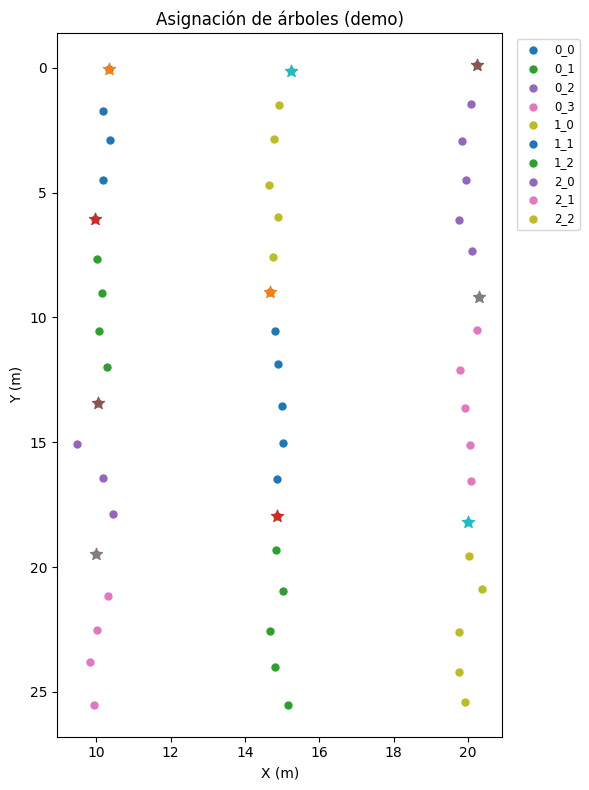

'\nCómo usarlo con tu CSV:\n\nimport pandas as pd\nfrom plan_cosecha_visual import assign_workers, plot_assignment\n\n# 1) Cargar datos --------------------------------------------\ndf = pd.read_csv("arboles_con_hileras.csv")   # columnas: tree_id,row_id,x,y,[weight]\nW  = 32                                       # trabajadores disponibles\n\n# 2) Asignar --------------------------------------------------\ndf_out, resumen = assign_workers(df, W, weight_col="weight")  # quita weight_col si no tienes\n\n# 3) Guardar resultados --------------------------------------\ndf_out.to_csv("plan_cosecha_detallado.csv", index=False)\nresumen.to_csv("plan_cosecha_resumen.csv", index=False)\n\n# 4) Visualizar ----------------------------------------------\nplot_assignment(df_out, title="Asignación de árboles (datos reales)")\n'

In [ ]:
#!/usr/bin/env python
"""
plan_cosecha_visual.py
----------------------
Asigna trabajadores a hileras y visualiza el plan resultante.

Autor  : <tu nombre>
Fecha  : 2025-06-10
Python : 3.9+

Requisitos:
    pip install pandas numpy matplotlib
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# 1)  Carga de trabajo y reparto de trabajadores
# ------------------------------------------------------------------
def workers_per_row(df: pd.DataFrame, W: int, weight_col: str | None = None
                    ) -> pd.DataFrame:
    """
    Calcula la carga y los trabajadores asignados a cada hilera.

    Parámetros
    ----------
    df : DataFrame con columnas 'row_id' y opcionalmente `weight_col`
    W  : int, total de trabajadores disponibles
    weight_col : str | None, si se indica utiliza esa columna como kilos;
                 si es None usa nº de árboles.

    Devuelve
    --------
    DataFrame con columnas [row_id, carga, workers]
    """
    if weight_col and weight_col in df.columns:
        carga = df.groupby("row_id")[weight_col].sum().rename("carga")
    else:
        carga = df.groupby("row_id").size().rename("carga")

    total = carga.sum()
    if total == 0:
        raise ValueError("La carga total es cero.")

    # Parte entera proporcional
    workers = np.floor(W * carga / total).astype(int)

    # Garantizar al menos 1 si es posible
    while (workers == 0).any() and workers.sum() < W:
        workers[workers == 0] += 1

    # Repartir sobrantes según residuo más alto
    sobrantes = W - workers.sum()
    if sobrantes > 0:
        residuo = (W * carga / total) - workers
        for idx in residuo.sort_values(ascending=False).index[:sobrantes]:
            workers[idx] += 1

    return pd.concat([carga, workers.rename("workers")], axis=1).reset_index()


# ------------------------------------------------------------------
# 2)  Segmentación de hileras y asignación
# ------------------------------------------------------------------
def segment_row(grp: pd.DataFrame, k: int, row_id) -> pd.DataFrame:
    """
    Divide la hilera (DataFrame grp) en k tramos contiguos y etiqueta
    cada árbol con worker_id, seg_idx e is_start.
    """
    grp = grp.sort_values("y").reset_index(drop=True)        # ordenar por Y
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)      # índices de corte

    worker_ids, seg_idxs, start_flags = [], [], []
    for w in range(k):
        ini, fin = cortes[w], cortes[w + 1]
        seg_idxs.extend([w] * (fin - ini))
        worker_ids.extend([f"{row_id}_{w}"] * (fin - ini))
        start_flags.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = worker_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = start_flags
    return out


def assign_workers(df: pd.DataFrame, W: int,
                   weight_col: str | None = None
                   ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Asigna trabajadores y devuelve:
        df_out  – DataFrame de árboles con worker_id, seg_idx, is_start
        resumen – tabla por hilera con carga y nº de workers
    """
    resumen = workers_per_row(df, W, weight_col)
    workers_map = dict(zip(resumen["row_id"], resumen["workers"]))

    partes = [
        segment_row(grp, workers_map[rid], rid)
        for rid, grp in df.groupby("row_id", sort=False)
    ]
    return pd.concat(partes, ignore_index=True), resumen


# ------------------------------------------------------------------
# 3)  Visualización
# ------------------------------------------------------------------
def plot_assignment(df_out: pd.DataFrame, title="Asignación de árboles"):
    """
    Pinta cada trabajador con un color distinto y marca su árbol inicial.
    """
    plt.figure(figsize=(6, 8))
    for worker, grp in df_out.groupby("worker_id"):
        plt.scatter(grp["x"], grp["y"], label=worker, s=25)
        starts = grp[grp["is_start"]]
        plt.scatter(starts["x"], starts["y"], marker='*', s=80)

    plt.gca().invert_yaxis()
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# 4)  DEMO con datos simulados
# ------------------------------------------------------------------
if __name__ == "__main__":
    # --- generar 3 hileras × 18 árboles cada una --------------
    np.random.seed(0)
    filas = []
    for row in range(3):
        for t in range(18):
            x = row * 5 + 10 + np.random.randn() * 0.2
            y = t * 1.5 + np.random.randn() * 0.1
            filas.append((f"tree_{row}_{t}", row, x, y))
    df_demo = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

    # --- parámetros de cosecha --------------------------------
    W = 10                                  # nº trabajadores

    # --- asignar y visualizar ---------------------------------
    df_out, resumen = assign_workers(df_demo, W)
    print("Resumen por hilera:\n", resumen, "\n")
    plot_assignment(df_out, title="Asignación de árboles (demo)")


# ------------------------------------------------------------------
# 5)  Con tus datos reales
# ------------------------------------------------------------------
"""
Cómo usarlo con tu CSV:

import pandas as pd
from plan_cosecha_visual import assign_workers, plot_assignment

# 1) Cargar datos --------------------------------------------
df = pd.read_csv("arboles_con_hileras.csv")   # columnas: tree_id,row_id,x,y,[weight]
W  = 32                                       # trabajadores disponibles

# 2) Asignar --------------------------------------------------
df_out, resumen = assign_workers(df, W, weight_col="weight")  # quita weight_col si no tienes

# 3) Guardar resultados --------------------------------------
df_out.to_csv("plan_cosecha_detallado.csv", index=False)
resumen.to_csv("plan_cosecha_resumen.csv", index=False)

# 4) Visualizar ----------------------------------------------
plot_assignment(df_out, title="Asignación de árboles (datos reales)")
"""


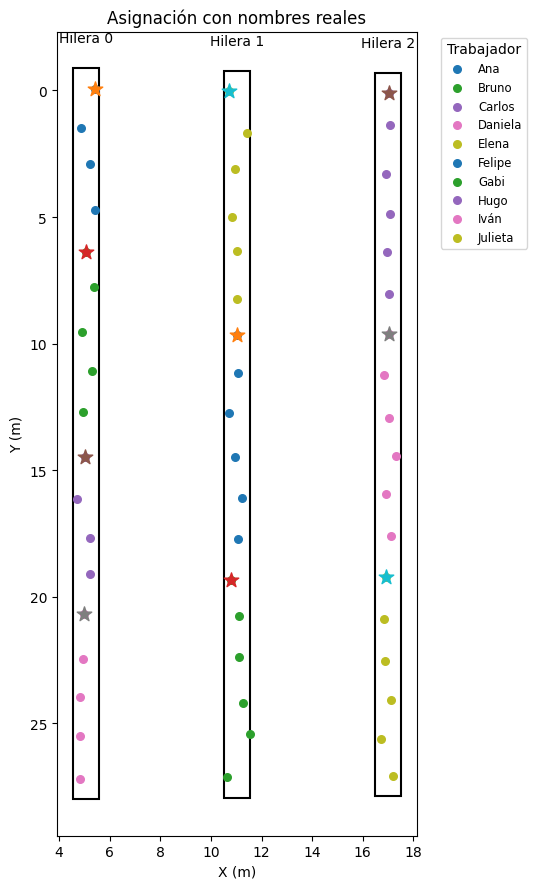

Resumen por hilera
    row_id  carga  workers
0       0     18        4
1       1     18        3
2       2     18        3 



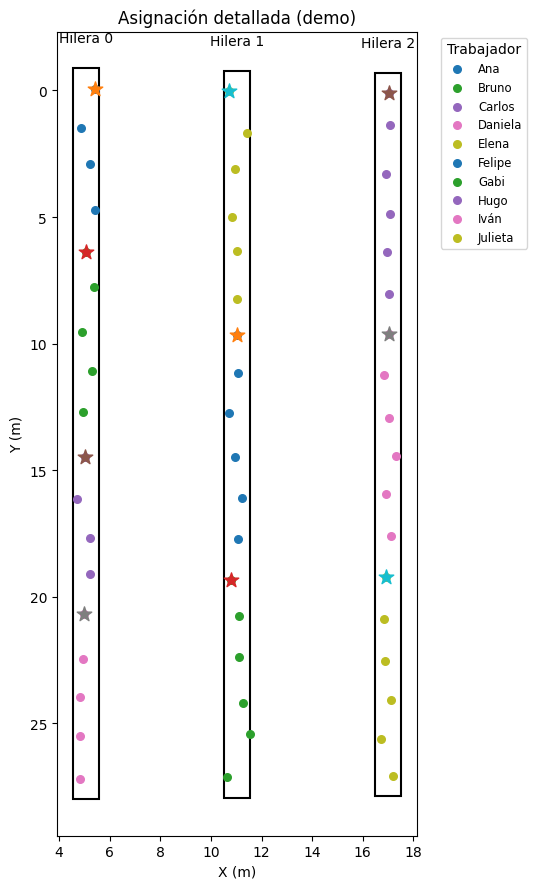

'\n# 1. Carga tu CSV con la geometría de árboles\nimport pandas as pd\nfrom plan_cosecha_dibujado import assign_workers, plot_assignment\n\ndf = pd.read_csv("arboles_con_hileras.csv")   # tree_id,row_id,x,y,[weight]\nW  = 32                                       # nº de trabajadores reales\n\n# 2. Ejecuta la asignación\ndf_out, resumen = assign_workers(df, W, weight_col="weight")  # quita weight_col si no la tienes\n\n# 3. Guarda o inspecciona resultados\ndf_out.to_csv("plan_detallado.csv", index=False)\nresumen.to_csv("plan_resumen.csv", index=False)\n\n# 4. Dibuja\nplot_assignment(df_out, title="Asignación detallada (datos reales)")\n'

In [ ]:
#!/usr/bin/env python
"""
plan_cosecha_dibujado.py
------------------------
1) Reparte proporcionalmente W trabajadores entre hileras.
2) Segmenta cada hilera y asigna bloques contiguos de árboles.
3) Dibuja:
   • Rectángulos = hileras
   • Puntos de colores = árboles por trabajador
   • Asterisco = árbol donde empieza cada trabajador
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# ------------------------------------------------------------------
# 1)  CÁLCULO DE CARGA Y REPARTO DE TRABAJADORES
# ------------------------------------------------------------------
def workers_per_row(df: pd.DataFrame, W: int, weight_col: str | None = None
                    ) -> pd.DataFrame:
    """Devuelve tabla [row_id, carga, workers]"""
    carga = (df.groupby("row_id")[weight_col].sum() if weight_col and weight_col in df.columns
             else df.groupby("row_id").size()).rename("carga")

    total = carga.sum()
    workers = np.floor(W * carga / total).astype(int)

    # Asegurar al menos 1 trabajador por hilera (si alcanzan)
    while (workers == 0).any() and workers.sum() < W:
        workers[workers == 0] += 1

    # Repartir sobrantes según residuo
    sobrantes = W - workers.sum()
    if sobrantes > 0:
        residuo = (W * carga / total) - workers
        for idx in residuo.sort_values(ascending=False).index[:sobrantes]:
            workers[idx] += 1

    return pd.concat([carga, workers.rename("workers")], axis=1).reset_index()


# ------------------------------------------------------------------
# 2)  SEGMENTACIÓN DE HILERA Y ASIGNACIÓN DE ÁRBOLES
# ------------------------------------------------------------------
def segment_row(grp: pd.DataFrame, k: int, row_id) -> pd.DataFrame:
    """Ordena la hilera por Y (cambiar a X si es horizontal) y asigna k trabajadores"""
    grp = grp.sort_values("y").reset_index(drop=True)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    worker_ids, seg_idxs, starts = [], [], []
    for w in range(k):
        ini, fin = cortes[w], cortes[w + 1]
        seg_idxs.extend([w] * (fin - ini))
        worker_ids.extend([f"{row_id}_{w}"] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = worker_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


def assign_workers_fixed(df: pd.DataFrame,
                         workers_list: list[str],
                         weight_col: str | None = None):
    """Asigna trabajadores con nombres predeterminados"""
    W = len(workers_list)
    resumen = workers_per_row(df, W, weight_col)
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    # Índice para ir sacando nombres
    cursor = 0
    partes = []
    for rid, grp in df.groupby("row_id", sort=False):
        k = mapa[rid]                      # trabajadores para esa hilera
        nombres = workers_list[cursor:cursor + k]
        cursor += k
        partes.append(segment_row_named(grp, nombres, rid))

    return pd.concat(partes, ignore_index=True), resumen


def segment_row_named(grp: pd.DataFrame,
                      names: list[str],
                      row_id):
    """Segmenta hilera y asigna los nombres dados"""
    grp = grp.sort_values("y").reset_index(drop=True)
    k = len(names)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    worker_ids, seg_idxs, starts = [], [], []
    for i, name in enumerate(names):
        ini, fin = cortes[i], cortes[i + 1]
        worker_ids.extend([name] * (fin - ini))
        seg_idxs.extend([i] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = worker_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out



# ------------------------------------------------------------------
# 3)  VISUALIZACIÓN DETALLADA
# ------------------------------------------------------------------
def plot_assignment(df_out: pd.DataFrame, title: str = "Asignación detallada"):
    """Dibuja hileras + árboles + punto inicial por trabajador"""
    fig, ax = plt.subplots(figsize=(7, 9))

    # (A) Rectángulos por hilera
    for rid, grp in df_out.groupby("row_id", sort=False):
        mean_x = grp["x"].mean()
        width  = 1.0                                # ancho aproximado de la hilera
        y0, y1 = grp["y"].min(), grp["y"].max()
        ax.add_patch(Rectangle((mean_x - width/2, y0 - 0.8),
                               width, (y1 - y0) + 1.6,
                               fill=False, linewidth=1.5))
        ax.text(mean_x, y0 - 2.0, f"Hilera {rid}",
                ha="center", va="center", fontsize="medium")

    # (B) Puntos por trabajador
    for worker, grp in df_out.groupby("worker_id"):
        ax.scatter(grp["x"], grp["y"], label=worker, s=30)
        starts = grp[grp["is_start"]]
        ax.scatter(starts["x"], starts["y"], marker='*', s=120)

    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(title)
    ax.legend(title="Trabajador", bbox_to_anchor=(1.05, 1),
              loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# 4)  DEMO RÁPIDO CON DATOS SIMULADOS
# ------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(1)
    filas = []
    for row in range(3):             # 3 hileras
        for t in range(18):          # 18 árboles cada una
            x = row * 6 + 5 + np.random.randn() * 0.25
            y = t * 1.6 + np.random.randn() * 0.12
            filas.append((f"tree_{row}_{t}", row, x, y))
    df_demo = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

    W = 10                           # trabajadores disponibles (demo)
    names = ["Ana", "Bruno", "Carlos", "Daniela",
         "Elena", "Felipe", "Gabi", "Hugo",
         "Iván", "Julieta"]               # 10 trabajadores fijos
    df_out, resumen = assign_workers_fixed(df_demo, names)
    plot_assignment(df_out, title="Asignación con nombres reales")

    print("Resumen por hilera\n", resumen, "\n")
    plot_assignment(df_out, title="Asignación detallada (demo)")


# ------------------------------------------------------------------
# 5)  CON TUS DATOS REALES
# ------------------------------------------------------------------
"""
# 1. Carga tu CSV con la geometría de árboles
import pandas as pd
from plan_cosecha_dibujado import assign_workers, plot_assignment

df = pd.read_csv("arboles_con_hileras.csv")   # tree_id,row_id,x,y,[weight]
W  = 32                                       # nº de trabajadores reales

# 2. Ejecuta la asignación
df_out, resumen = assign_workers(df, W, weight_col="weight")  # quita weight_col si no la tienes

# 3. Guarda o inspecciona resultados
df_out.to_csv("plan_detallado.csv", index=False)
resumen.to_csv("plan_resumen.csv", index=False)

# 4. Dibuja
plot_assignment(df_out, title="Asignación detallada (datos reales)")
"""


In [ ]:
#Trabajadores que me gustaría tener
# ------------------------------------------------------------------
# 3)  VISUALIZACIÓN DETALLADA  (versión mejorada)
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import numpy as np

def _color_palette(n):
    """
    Devuelve una lista de n colores únicos.
    - Para n ≤ 20 usa el cmap 'tab20'.
    - Para n > 20 genera n colores equiespaciados en HSV.
    """
    if n <= 20:
        cmap = mpl.colormaps.get_cmap('tab20')
        return [cmap(i) for i in range(n)]
    # HSV: tonos distribuidos uniformemente
    hsv = [(i / n, 0.75, 0.9) for i in range(n)]
    return mpl.colors.hsv_to_rgb(hsv)

def plot_assignment(df_out, title="Asignación detallada"):
    """Dibuja hileras + árboles con color único por trabajador
       e identifica la hilera en la leyenda.
    """
    fig, ax = plt.subplots(figsize=(7, 9))

    # (A) Rectángulos por hilera
    for rid, grp in df_out.groupby("row_id", sort=False):
        mean_x = grp["x"].mean()
        width  = 1.0
        y0, y1 = grp["y"].min(), grp["y"].max()
        ax.add_patch(Rectangle((mean_x - width/2, y0 - 0.8),
                               width, (y1 - y0) + 1.6,
                               fill=False, linewidth=1.5))
        ax.text(mean_x, y0 - 2.0, f"Hilera {rid}",
                ha="center", va="center", fontsize="medium")

    # (B) Puntos por trabajador con colores únicos
    workers = sorted(df_out["worker_id"].unique())      # orden estable
    colores = _color_palette(len(workers))
    color_map = dict(zip(workers, colores))

    for worker in workers:
        grp  = df_out[df_out["worker_id"] == worker]
        rid  = grp["row_id"].iloc[0]                    # hilera asignada
        lab  = f"{worker}  (Hilera {rid})"
        col  = color_map[worker]

        ax.scatter(grp["x"], grp["y"], s=30, color=col, label=lab)
        starts = grp[grp["is_start"]]
        ax.scatter(starts["x"], starts["y"], marker='*', s=120, color=col)

    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(title)
    ax.legend(title="Trabajador", bbox_to_anchor=(1.05, 1),
              loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


In [ ]:
df_out, resumen = assign_workers(df_arboles, W)   # o assign_workers_fixed(...)
plot_assignment(df_out, title="Asignación detallada")

NameError: name 'df_arboles' is not defined

Resumen genérico
    row_id  carga  workers
0       0     18        4
1       1     18        3
2       2     18        3 



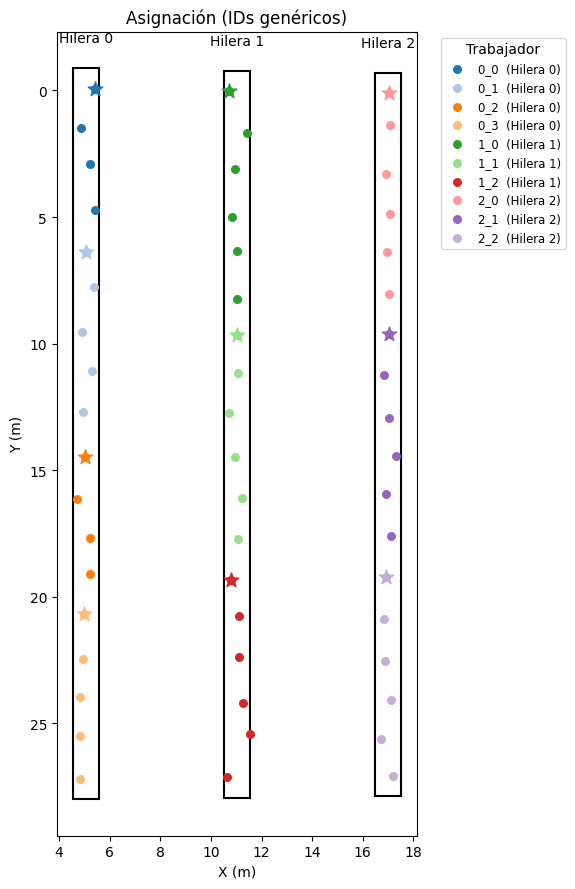

Resumen con nombres
    row_id  carga  workers
0       0     18        4
1       1     18        3
2       2     18        3 



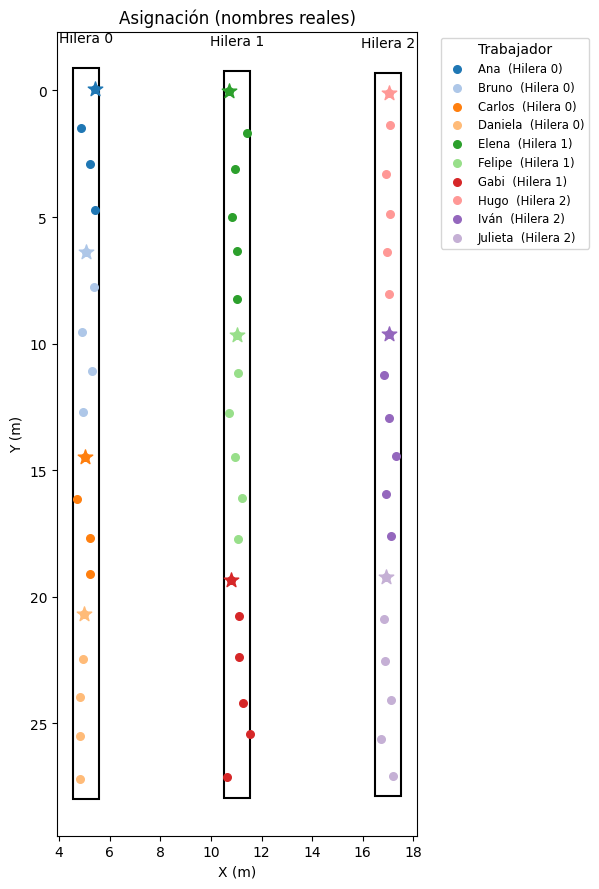

'\n# 1. Carga tu CSV con la geometría de árboles\nimport pandas as pd\nfrom plan_cosecha_dibujado import assign_workers, assign_workers_fixed, plot_assignment\n\ndf = pd.read_csv("arboles_con_hileras.csv")   # columnas: tree_id,row_id,x,y,[weight]\n\n# Opción A) Solo conoces cuántos trabajadores\nW = 32\ndf_out, resumen = assign_workers(df, W, weight_col="weight")  # quita weight_col si no hay\n\n# Opción B) Tienes la lista de nombres\nnombres = [...]  # lista[str] con los 32 nombres\ndf_out, resumen = assign_workers_fixed(df, nombres, weight_col="weight")\n\n# 2. Guarda o inspecciona resultados\ndf_out.to_csv("plan_detallado.csv", index=False)\nresumen.to_csv("plan_resumen.csv", index=False)\n\n# 3. Dibuja\nplot_assignment(df_out, title="Asignación detallada (datos reales)")\n'

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
plan_cosecha_dibujado.py
------------------------
1) Reparte proporcionalmente W trabajadores entre hileras (o usa una lista fija).
2) Segmenta cada hilera y asigna bloques contiguos de árboles.
3) Dibuja:
   • Rectángulos = hileras
   • Puntos de colores únicos = árboles por trabajador
   • Asterisco     = árbol donde empieza cada trabajador
   • Leyenda       = «Trabajador  (Hilera X)»
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl


# ------------------------------------------------------------------
# 1)  CÁLCULO DE CARGA Y REPARTO DE TRABAJADORES
# ------------------------------------------------------------------
def workers_per_row(df: pd.DataFrame, W: int,
                    weight_col: str | None = None) -> pd.DataFrame:
    """Devuelve tabla [row_id, carga, workers] con reparto proporcional."""
    carga = (df.groupby("row_id")[weight_col].sum()
             if weight_col and weight_col in df.columns
             else df.groupby("row_id").size()).rename("carga")

    total = carga.sum()
    workers = np.floor(W * carga / total).astype(int)

    # Asegurar al menos 1 trabajador por hilera (si alcanzan)
    while (workers == 0).any() and workers.sum() < W:
        workers[workers == 0] += 1

    # Repartir sobrantes según residuo
    sobrantes = W - workers.sum()
    if sobrantes > 0:
        residuo = (W * carga / total) - workers
        for idx in residuo.sort_values(ascending=False).index[:sobrantes]:
            workers[idx] += 1

    return pd.concat([carga, workers.rename("workers")], axis=1).reset_index()


# ------------------------------------------------------------------
# 2)  SEGMENTACIÓN DE HILERA Y ASIGNACIÓN DE ÁRBOLES
# ------------------------------------------------------------------
def segment_row(grp: pd.DataFrame, k: int, row_id) -> pd.DataFrame:
    """Segmenta la hilera en k bloques para k trabajadores genéricos."""
    grp = grp.sort_values("y").reset_index(drop=True)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    worker_ids, seg_idxs, starts = [], [], []
    for w in range(k):
        ini, fin = cortes[w], cortes[w + 1]
        seg_idxs.extend([w] * (fin - ini))
        worker_ids.extend([f"{row_id}_{w}"] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = worker_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


def segment_row_named(grp: pd.DataFrame, names: list[str], row_id) -> pd.DataFrame:
    """Segmenta la hilera y asigna *los nombres dados* de trabajadores."""
    grp = grp.sort_values("y").reset_index(drop=True)
    k = len(names)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    worker_ids, seg_idxs, starts = [], [], []
    for i, name in enumerate(names):
        ini, fin = cortes[i], cortes[i + 1]
        worker_ids.extend([name] * (fin - ini))
        seg_idxs.extend([i] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = worker_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


def assign_workers(df: pd.DataFrame, W: int,
                   weight_col: str | None = None
                   ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Asigna bloques usando solo el número de trabajadores W.
    Devuelve df_out (árboles con worker_id, seg_idx, is_start) y resumen hileras.
    """
    resumen = workers_per_row(df, W, weight_col)
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    partes = [segment_row(grp, mapa[rid], rid)
              for rid, grp in df.groupby("row_id", sort=False)]
    return pd.concat(partes, ignore_index=True), resumen


def assign_workers_fixed(df: pd.DataFrame, workers_list: list[str],
                         weight_col: str | None = None
                         ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Asigna bloques usando una lista fija de nombres (orden estable).
    Lanza ValueError si faltan nombres; los excedentes quedan sin usar.
    """
    W = len(workers_list)
    resumen = workers_per_row(df, W, weight_col)
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    if resumen["workers"].sum() > W:
        raise ValueError("La lista de nombres es insuficiente para cubrir la asignación.")

    cursor = 0
    partes = []
    for rid, grp in df.groupby("row_id", sort=False):
        k = mapa[rid]
        nombres = workers_list[cursor:cursor + k]
        cursor += k
        partes.append(segment_row_named(grp, nombres, rid))

    return pd.concat(partes, ignore_index=True), resumen


# ------------------------------------------------------------------
# 3)  VISUALIZACIÓN DETALLADA
# ------------------------------------------------------------------
def _color_palette(n: int):
    """
    Genera n colores únicos:
    - n ≤ 20 : usa cmap 'tab20'.
    - n  > 20: distribuye tonos en HSV.
    """
    if n <= 20:
        cmap = mpl.colormaps.get_cmap('tab20')
        return [cmap(i) for i in range(n)]
    hsv = [(i / n, 0.75, 0.9) for i in range(n)]
    return mpl.colors.hsv_to_rgb(hsv)


def plot_assignment(df_out: pd.DataFrame, title: str = "Asignación detallada"):
    """Dibuja hileras, árboles y trabajador (color exclusivo)."""
    fig, ax = plt.subplots(figsize=(7, 9))

    # Rectángulos por hilera
    for rid, grp in df_out.groupby("row_id", sort=False):
        mean_x = grp["x"].mean()
        width  = 1.0
        y0, y1 = grp["y"].min(), grp["y"].max()
        ax.add_patch(Rectangle((mean_x - width/2, y0 - 0.8),
                               width, (y1 - y0) + 1.6,
                               fill=False, linewidth=1.5))
        ax.text(mean_x, y0 - 2.0, f"Hilera {rid}",
                ha="center", va="center", fontsize="medium")

    # Puntos de cada trabajador
    workers = sorted(df_out["worker_id"].unique())      # orden alfabético estable
    colores = _color_palette(len(workers))
    color_map = dict(zip(workers, colores))

    for worker in workers:
        grp = df_out[df_out["worker_id"] == worker]
        rid = grp["row_id"].iloc[0]
        etiqueta = f"{worker}  (Hilera {rid})"
        col = color_map[worker]

        ax.scatter(grp["x"], grp["y"], s=30, color=col, label=etiqueta)
        starts = grp[grp["is_start"]]
        ax.scatter(starts["x"], starts["y"], marker='*', s=120, color=col)

    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(title)
    ax.legend(title="Trabajador", bbox_to_anchor=(1.05, 1),
              loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# 4)  DEMO RÁPIDO CON DATOS SIMULADOS
# ------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(1)

    # Simulamos 3 hileras × 18 árboles
    filas = []
    for row in range(3):
        for t in range(18):
            x = row * 6 + 5 + np.random.randn() * 0.25   # separación 6 m
            y = t * 1.6 + np.random.randn() * 0.12       # árbol cada 1,6 m
            filas.append((f"tree_{row}_{t}", row, x, y))

    df_demo = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

    # --- Versión con Nº de trabajadores (genéricos) -----------------
    W = 10
    df_out, resumen = assign_workers(df_demo, W)
    print("Resumen genérico\n", resumen, "\n")
    plot_assignment(df_out, title="Asignación (IDs genéricos)")

    # --- Versión con nombres concretos ------------------------------
    nombres = ["Ana", "Bruno", "Carlos", "Daniela", "Elena",
               "Felipe", "Gabi", "Hugo", "Iván", "Julieta"]  # 10 personas
    df_out2, resumen2 = assign_workers_fixed(df_demo, nombres)
    print("Resumen con nombres\n", resumen2, "\n")
    plot_assignment(df_out2, title="Asignación (nombres reales)")


# ------------------------------------------------------------------
# 5)  USO CON TUS DATOS REALES
# ------------------------------------------------------------------
"""
# 1. Carga tu CSV con la geometría de árboles
import pandas as pd
from plan_cosecha_dibujado import assign_workers, assign_workers_fixed, plot_assignment

df = pd.read_csv("arboles_con_hileras.csv")   # columnas: tree_id,row_id,x,y,[weight]

# Opción A) Solo conoces cuántos trabajadores
W = 32
df_out, resumen = assign_workers(df, W, weight_col="weight")  # quita weight_col si no hay

# Opción B) Tienes la lista de nombres
nombres = [...]  # lista[str] con los 32 nombres
df_out, resumen = assign_workers_fixed(df, nombres, weight_col="weight")

# 2. Guarda o inspecciona resultados
df_out.to_csv("plan_detallado.csv", index=False)
resumen.to_csv("plan_resumen.csv", index=False)

# 3. Dibuja
plot_assignment(df_out, title="Asignación detallada (datos reales)")
"""


Resumen (nº trabajadores)
    row_id  carga  workers
0       0     18        4
1       1     18        3
2       2     18        3 



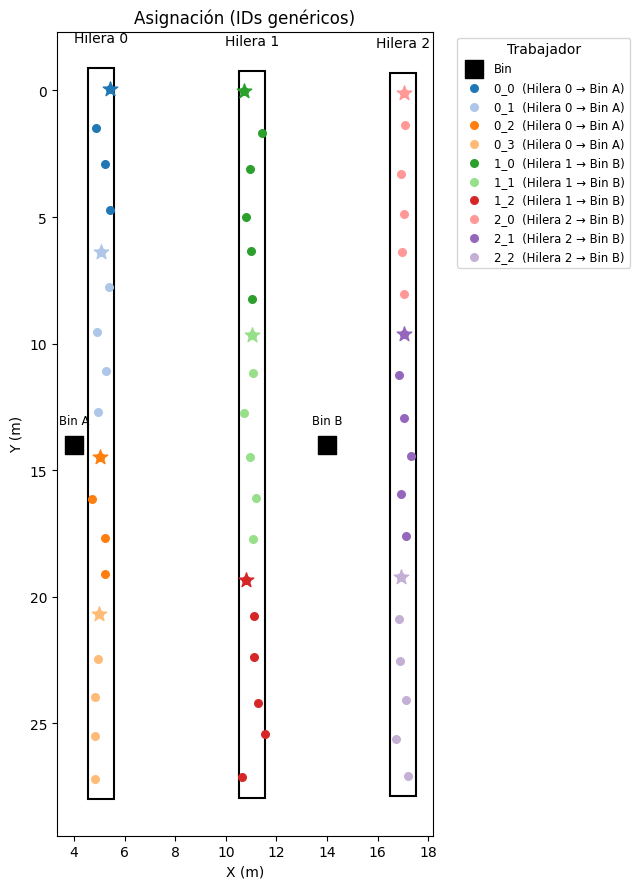

Resumen (nombres)
    row_id  carga  workers
0       0     18        4
1       1     18        3
2       2     18        3 



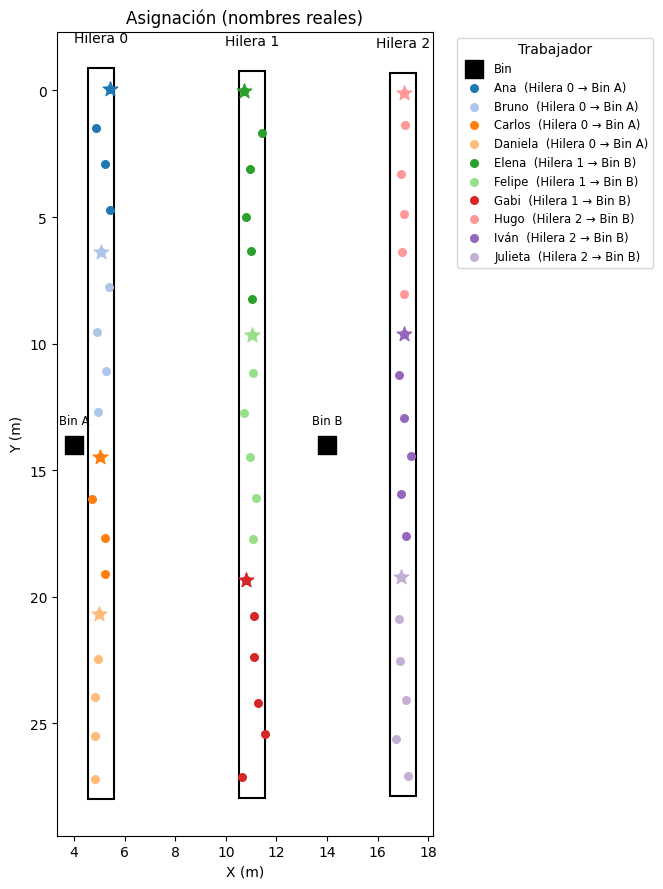

'\n# 1. Carga árboles y bins\nimport pandas as pd\nfrom plan_cosecha_dibujado_v2 import assign_workers, plot_assignment\n\ndf = pd.read_csv("arboles_con_hileras.csv")       # tree_id,row_id,x,y,[weight]\nbins = pd.read_csv("bins.csv")                    # bin_id,x,y\nW = 32                                            # o lista de nombres\n\n# 2. Asignación\ndf_out, resumen = assign_workers(df, bins, W, weight_col="weight")\n\n# 3. Guarda y dibuja\ndf_out.to_csv("plan_detallado.csv", index=False)\nresumen.to_csv("plan_resumen.csv", index=False)\nplot_assignment(df_out, bins, "Asignación detallada (con bins)")\n'

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
plan_cosecha_dibujado_v2.py
--------------------------------
• Reparte trabajadores entre hileras (o con nombres fijos).
• Asigna cada hilera al bin más cercano (puede haber varios).
• Segmenta árboles en bloques contiguos.
• Dibuja hileras, árboles, bins y leyenda:
     «Trabajador  (Hilera X → Bin Y)»
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl


# ------------------------------------------------------------------
# 0)  AYUDAS
# ------------------------------------------------------------------
def _color_palette(n: int):
    """n colores distintos (tab20 hasta 20, HSV si >20)."""
    if n <= 20:
        cmap = mpl.colormaps.get_cmap("tab20")
        return [cmap(i) for i in range(n)]
    hsv = [(i / n, 0.75, 0.9) for i in range(n)]
    return mpl.colors.hsv_to_rgb(hsv)


def _nearest_bin_id(x: float, y: float, bins_df: pd.DataFrame) -> str:
    """Devuelve el bin_id más cercano al punto (x,y)."""
    d = np.hypot(bins_df["x"] - x, bins_df["y"] - y)
    return bins_df.loc[d.idxmin(), "bin_id"]


# ------------------------------------------------------------------
# 1)  REPARTO DE TRABAJADORES POR HILERA
# ------------------------------------------------------------------
def workers_per_row(df: pd.DataFrame, W: int,
                    weight_col: str | None = None) -> pd.DataFrame:
    """Tabla [row_id, carga, workers] proporcional a la carga."""
    carga = (df.groupby("row_id")[weight_col].sum()
             if weight_col and weight_col in df.columns
             else df.groupby("row_id").size()).rename("carga")

    total = carga.sum()
    workers = np.floor(W * carga / total).astype(int)

    # Asegurar ≥1 trabajador/hilera (si alcanzan)
    while (workers == 0).any() and workers.sum() < W:
        workers[workers == 0] += 1

    # Repartir sobrantes por residuo
    sobrantes = W - workers.sum()
    if sobrantes > 0:
        residuo = (W * carga / total) - workers
        for idx in residuo.sort_values(ascending=False).index[:sobrantes]:
            workers[idx] += 1

    return pd.concat([carga, workers.rename("workers")], axis=1).reset_index()


# ------------------------------------------------------------------
# 2)  SEGMENTACIÓN DE HILERA
# ------------------------------------------------------------------
def segment_row(grp: pd.DataFrame, k: int, row_id) -> pd.DataFrame:
    """Bloques contiguos para k trabajadores genéricos."""
    grp = grp.sort_values("y").reset_index(drop=True)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    w_ids, seg_idxs, starts = [], [], []
    for i in range(k):
        ini, fin = cortes[i], cortes[i + 1]
        w_ids.extend([f"{row_id}_{i}"] * (fin - ini))
        seg_idxs.extend([i] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = w_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


def segment_row_named(grp: pd.DataFrame, names: list[str], row_id) -> pd.DataFrame:
    """Bloques contiguos usando lista de nombres."""
    grp = grp.sort_values("y").reset_index(drop=True)
    k = len(names)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    w_ids, seg_idxs, starts = [], [], []
    for i, name in enumerate(names):
        ini, fin = cortes[i], cortes[i + 1]
        w_ids.extend([name] * (fin - ini))
        seg_idxs.extend([i] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = w_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


# ------------------------------------------------------------------
# 3)  ASIGNACIÓN CON O SIN NOMBRES
# ------------------------------------------------------------------
def assign_workers(df: pd.DataFrame,
                   bins_df: pd.DataFrame,
                   W: int,
                   weight_col: str | None = None
                   ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Entrada: df árboles y df bins (bin_id,x,y).
    Salida: df_out (árboles con worker_id, bin_id, ...) y resumen por hilera.
    """
    # --- 3.1 Hilera → bin más cercano ------------------------------
    row_cent = df.groupby("row_id")[["x", "y"]].mean()
    row_cent["bin_id"] = row_cent.apply(
        lambda r: _nearest_bin_id(r["x"], r["y"], bins_df), axis=1)
    row_to_bin = row_cent["bin_id"].to_dict()

    df = df.copy()
    df["bin_id"] = df["row_id"].map(row_to_bin)

    # --- 3.2 Reparto de trabajadores por hilera --------------------
    resumen = workers_per_row(df, W, weight_col)
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    partes = [segment_row(df[df["row_id"] == rid], mapa[rid], rid)
              for rid in df["row_id"].unique()]
    df_out = pd.concat(partes, ignore_index=True)
    df_out["bin_id"] = df_out["row_id"].map(row_to_bin)
    return df_out, resumen


def assign_workers_fixed(df: pd.DataFrame,
                         bins_df: pd.DataFrame,
                         workers_list: list[str],
                         weight_col: str | None = None
                         ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Versión con nombres fijos."""
    # Hilera → bin
    row_cent = df.groupby("row_id")[["x", "y"]].mean()
    row_cent["bin_id"] = row_cent.apply(
        lambda r: _nearest_bin_id(r["x"], r["y"], bins_df), axis=1)
    row_to_bin = row_cent["bin_id"].to_dict()

    df = df.copy()
    df["bin_id"] = df["row_id"].map(row_to_bin)

    # Reparto trabajadores/hilera
    W = len(workers_list)
    resumen = workers_per_row(df, W, weight_col)
    if resumen["workers"].sum() > W:
        raise ValueError("Lista de nombres insuficiente.")
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    cursor = 0
    partes = []
    for rid in df["row_id"].unique():
        k = mapa[rid]
        nombres = workers_list[cursor:cursor + k]
        cursor += k
        partes.append(segment_row_named(df[df["row_id"] == rid],
                                        nombres, rid))
    df_out = pd.concat(partes, ignore_index=True)
    df_out["bin_id"] = df_out["row_id"].map(row_to_bin)
    return df_out, resumen


# ------------------------------------------------------------------
# 4)  GRÁFICO
# ------------------------------------------------------------------
def plot_assignment(df_out: pd.DataFrame,
                    bins_df: pd.DataFrame,
                    title: str = "Asignación detallada"):
    """Dibuja hileras, trabajadores (color único) y bins."""
    fig, ax = plt.subplots(figsize=(7, 9))

    # --- 4.1 Rectángulos hilera ------------------------------------
    for rid, grp in df_out.groupby("row_id", sort=False):
        mean_x = grp["x"].mean()
        width  = 1.0
        y0, y1 = grp["y"].min(), grp["y"].max()
        ax.add_patch(Rectangle((mean_x - width/2, y0 - 0.8),
                               width, (y1 - y0) + 1.6,
                               fill=False, linewidth=1.5))
        ax.text(mean_x, y0 - 2.0, f"Hilera {rid}",
                ha="center", va="center", fontsize="medium")

    # --- 4.2 Bins ---------------------------------------------------
    ax.scatter(bins_df["x"], bins_df["y"],
               marker="s", s=150, color="k", label="Bin")
    for _, r in bins_df.iterrows():
        ax.text(r["x"], r["y"] - 1.2, f"Bin {r['bin_id']}",
                ha="center", va="top", fontsize="small")

    # --- 4.3 Trabajadores ------------------------------------------
    workers = sorted(df_out["worker_id"].unique())
    colores = _color_palette(len(workers))
    color_map = dict(zip(workers, colores))

    for worker in workers:
        g = df_out[df_out["worker_id"] == worker]
        rid  = g["row_id"].iloc[0]
        bid  = g["bin_id"].iloc[0]
        lab  = f"{worker}  (Hilera {rid} → Bin {bid})"
        col  = color_map[worker]

        ax.scatter(g["x"], g["y"], s=30, color=col, label=lab)
        starts = g[g["is_start"]]
        ax.scatter(starts["x"], starts["y"], marker="*", s=120, color=col)

    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(title)
    ax.legend(title="Trabajador", bbox_to_anchor=(1.05, 1),
              loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# 5)  DEMO CON DATOS SIMULADOS
# ------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(1)

    # -- Árboles: 3 hileras × 18 árboles ----------------------------
    filas = []
    for row in range(3):
        for t in range(18):
            x = row * 6 + 5 + np.random.randn() * 0.25
            y = t * 1.6 + np.random.randn() * 0.12
            filas.append((f"tree_{row}_{t}", row, x, y))
    df_trees = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

    # -- Bins: dos ubicaciones de ejemplo ---------------------------
    bins_demo = pd.DataFrame({
        "bin_id": ["A", "B"],
        "x": [4, 14],                 # a la izquierda y derecha del huerto
        "y": [14, 14]
    })

    # --- A) Con número de trabajadores -----------------------------
    W = 10
    df_out, resumen = assign_workers(df_trees, bins_demo, W)
    print("Resumen (nº trabajadores)\n", resumen, "\n")
    plot_assignment(df_out, bins_demo, "Asignación (IDs genéricos)")

    # --- B) Con nombres --------------------------------------------
    nombres = ["Ana", "Bruno", "Carlos", "Daniela", "Elena",
               "Felipe", "Gabi", "Hugo", "Iván", "Julieta"]
    df_out2, resumen2 = assign_workers_fixed(df_trees, bins_demo, nombres)
    print("Resumen (nombres)\n", resumen2, "\n")
    plot_assignment(df_out2, bins_demo, "Asignación (nombres reales)")


# ------------------------------------------------------------------
# 6)  TUS DATOS REALES
# ------------------------------------------------------------------
"""
# 1. Carga árboles y bins
import pandas as pd
from plan_cosecha_dibujado_v2 import assign_workers, plot_assignment

df = pd.read_csv("arboles_con_hileras.csv")       # tree_id,row_id,x,y,[weight]
bins = pd.read_csv("bins.csv")                    # bin_id,x,y
W = 32                                            # o lista de nombres

# 2. Asignación
df_out, resumen = assign_workers(df, bins, W, weight_col="weight")

# 3. Guarda y dibuja
df_out.to_csv("plan_detallado.csv", index=False)
resumen.to_csv("plan_resumen.csv", index=False)
plot_assignment(df_out, bins, "Asignación detallada (con bins)")
"""


In [ ]:
if __name__ == "__main__":
    np.random.seed(1)

    # ---- Cantidad deseada en cada hilera -------------------------
    trees_per_row = [18, 24, 15]          # hilera 0:18, 1:24, 2:15
    filas = []
    for row, n_trees in enumerate(trees_per_row):
        for t in range(n_trees):
            x = row * 6 + 5 + np.random.randn() * 0.25   # posición X
            y = t * 1.6 + np.random.randn() * 0.12       # posición Y
            filas.append((f"tree_{row}_{t}", row, x, y))

    df_trees = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

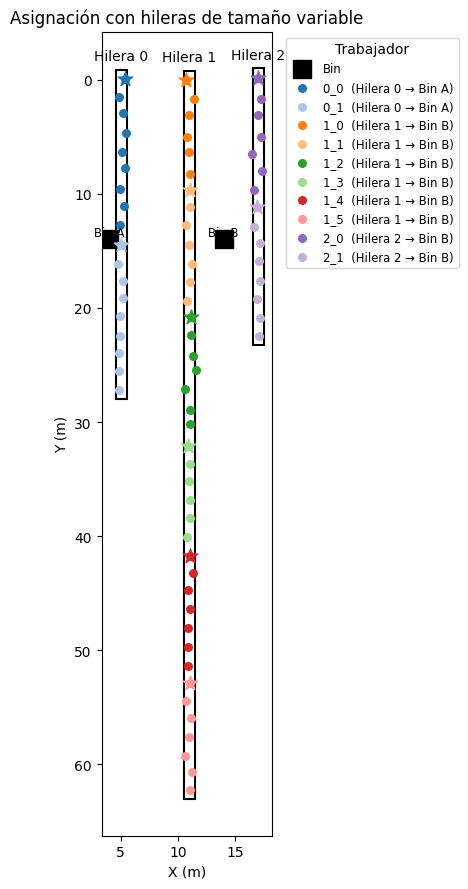

In [ ]:
df_out, resumen = assign_workers(df_trees, bins_demo, W)
plot_assignment(df_out, bins_demo, "Asignación con hileras de tamaño variable")


Trabajadores necesarios (demo): 12

Resumen por hilera
    row_id  carga  workers
0       0     18        4
1       1     24        5
2       2     15        3 



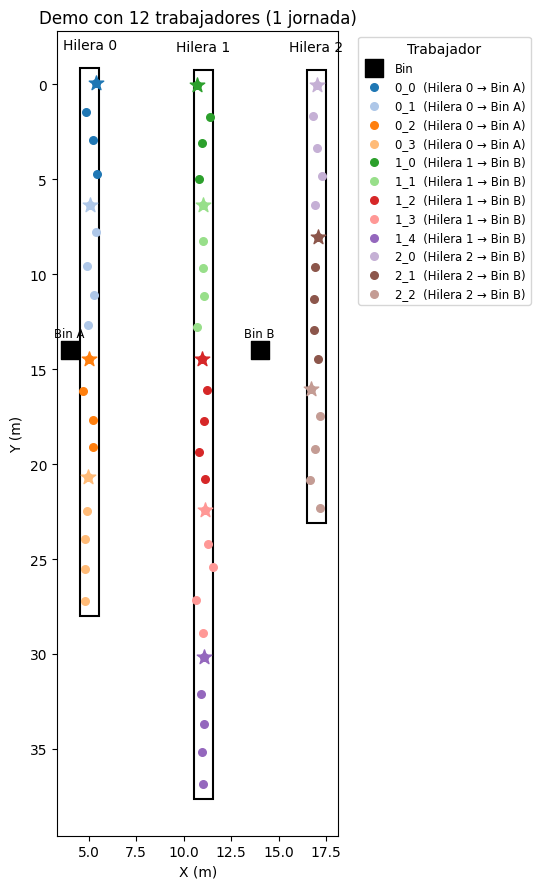

'\n# 1) Carga árboles y bins\nimport pandas as pd\nfrom plan_cosecha_dibujado_v3 import (estimate_required_workers,\n                                      assign_workers, plot_assignment)\n\ndf    = pd.read_csv("arboles_con_hileras.csv")   # tree_id,row_id,x,y,[weight]\nbins  = pd.read_csv("bins.csv")                  # bin_id,x,y\n\n# 2) Calcula W necesario\nW = estimate_required_workers(df,               # o ajusta constantes arriba\n                              trees_per_worker_day=320,\n                              kg_per_worker_day=None,\n                              weight_col=None)\nprint(f"Se necesitan {W} trabajadores para 1 jornada.")\n\n# 3) Asignación (o usa assign_workers_fixed con nombres)\ndf_out, resumen = assign_workers(df, bins, W)\n\n# 4) Guarda y dibuja\ndf_out.to_csv("plan_detallado.csv", index=False)\nresumen.to_csv("plan_resumen.csv", index=False)\nplot_assignment(df_out, bins,\n                title=f"Asignación detallada con {W} trabajadores")\n'

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
plan_cosecha_dibujado_v3.py
------------------------------------------------
• Estima cuántos trabajadores se requieren para 1 jornada.
• Reparte trabajadores (o nombres fijos) entre hileras.
• Asigna cada hilera al bin más cercano.
• Segmenta bloques contiguos dentro de la hilera.
• Dibuja hileras, árboles, bins y leyenda:
      «Trabajador  (Hilera X → Bin Y)»
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl


# ==========================================================================
# 0)  CONSTANTES DE PRODUCTIVIDAD (ajusta a tu realidad)
# ==========================================================================
     # árboles que cosecha un trabajador en 1 jornada
KG_PER_WORKER_DAY    = 1      # kilos que cosecha un trabajador en 1 jornada
# Si tu DataFrame tiene columna "weight" (kilos por árbol), usa KG_PER_WORKER_DAY.
# Si no, el cálculo se hace por número de árboles con TREES_PER_WORKER_DAY.


# ==========================================================================
# 1)  UTILIDADES GENERALES
# ==========================================================================
def _color_palette(n: int):
    """Devuelve n colores distintos (tab20 hasta 20, HSV si >20)."""
    if n <= 20:
        cmap = mpl.colormaps.get_cmap("tab20")
        return [cmap(i) for i in range(n)]
    hsv = [(i / n, 0.75, 0.9) for i in range(n)]
    return mpl.colors.hsv_to_rgb(hsv)


def _nearest_bin_id(x: float, y: float, bins_df: pd.DataFrame) -> str:
    """Id del bin más cercano al punto (x,y)."""
    d = np.hypot(bins_df["x"] - x, bins_df["y"] - y)
    return bins_df.loc[d.idxmin(), "bin_id"]

TREES_PER_WORKER_DAY = 5
# ==========================================================================
# 2)  ESTIMACIÓN DE TRABAJADORES PARA 1 JORNADA
# ==========================================================================
def estimate_required_workers(df: pd.DataFrame,
                              trees_per_worker_day: int | None = TREES_PER_WORKER_DAY,
                              kg_per_worker_day:    int | None = KG_PER_WORKER_DAY,
                              weight_col: str | None = None) -> int:
    """
    Nº mínimo de trabajadores para completar la cosecha en 1 jornada.

    • Si existe `weight_col` y das `kg_per_worker_day`, usa kilos totales.
    • En caso contrario, usa nº de árboles y `trees_per_worker_day`.
    """
    if weight_col and weight_col in df.columns and kg_per_worker_day:
        total_carga = df[weight_col].sum()    # kilos
        capacidad   = kg_per_worker_day
    else:
        total_carga = len(df)                 # árboles
        if trees_per_worker_day is None:
            raise ValueError("Debes indicar trees_per_worker_day "
                             "o usar weight_col + kg_per_worker_day")
        capacidad = trees_per_worker_day

    return int(np.ceil(total_carga / capacidad))


# ==========================================================================
# 3)  REPARTO DE TRABAJADORES POR HILERA
# ==========================================================================
def workers_per_row(df: pd.DataFrame, W: int,
                    weight_col: str | None = None) -> pd.DataFrame:
    """Tabla [row_id, carga, workers] proporcional a la carga."""
    carga = (df.groupby("row_id")[weight_col].sum()
             if weight_col and weight_col in df.columns
             else df.groupby("row_id").size()).rename("carga")

    total = carga.sum()
    workers = np.floor(W * carga / total).astype(int)

    # Asegurar ≥1 trabajador/hilera (si alcanzan)
    while (workers == 0).any() and workers.sum() < W:
        workers[workers == 0] += 1

    # Repartir sobrantes por residuo
    sobrantes = W - workers.sum()
    if sobrantes > 0:
        residuo = (W * carga / total) - workers
        for idx in residuo.sort_values(ascending=False).index[:sobrantes]:
            workers[idx] += 1

    return pd.concat([carga, workers.rename("workers")], axis=1).reset_index()


# ==========================================================================
# 4)  SEGMENTACIÓN DE HILERA
# ==========================================================================
def segment_row(grp: pd.DataFrame, k: int, row_id) -> pd.DataFrame:
    """Bloques contiguos para k trabajadores genéricos."""
    grp = grp.sort_values("y").reset_index(drop=True)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    w_ids, seg_idxs, starts = [], [], []
    for i in range(k):
        ini, fin = cortes[i], cortes[i + 1]
        w_ids.extend([f"{row_id}_{i}"] * (fin - ini))
        seg_idxs.extend([i] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = w_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


def segment_row_named(grp: pd.DataFrame, names: list[str], row_id) -> pd.DataFrame:
    """Bloques contiguos usando lista de nombres."""
    grp = grp.sort_values("y").reset_index(drop=True)
    k = len(names)
    cortes = np.linspace(0, len(grp), k + 1, dtype=int)

    w_ids, seg_idxs, starts = [], [], []
    for i, name in enumerate(names):
        ini, fin = cortes[i], cortes[i + 1]
        w_ids.extend([name] * (fin - ini))
        seg_idxs.extend([i] * (fin - ini))
        starts.extend([True] + [False] * (fin - ini - 1))

    out = grp.copy()
    out["worker_id"] = w_ids
    out["seg_idx"]   = seg_idxs
    out["is_start"]  = starts
    return out


# ==========================================================================
# 5)  ASIGNACIÓN CON O SIN NOMBRES (considerando bins)
# ==========================================================================
def assign_workers(df: pd.DataFrame,
                   bins_df: pd.DataFrame,
                   W: int,
                   weight_col: str | None = None
                   ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Entrada: df árboles y df bins (bin_id,x,y).
    Salida: df_out (árboles con worker_id, bin_id, ...) y resumen por hilera.
    """
    # 5.1 Hilera → bin más cercano
    row_cent = df.groupby("row_id")[["x", "y"]].mean()
    row_cent["bin_id"] = row_cent.apply(
        lambda r: _nearest_bin_id(r["x"], r["y"], bins_df), axis=1)
    row_to_bin = row_cent["bin_id"].to_dict()

    df = df.copy()
    df["bin_id"] = df["row_id"].map(row_to_bin)

    # 5.2 Reparto trabajadores/hilera
    resumen = workers_per_row(df, W, weight_col)
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    partes = [segment_row(df[df["row_id"] == rid], mapa[rid], rid)
              for rid in df["row_id"].unique()]
    df_out = pd.concat(partes, ignore_index=True)
    df_out["bin_id"] = df_out["row_id"].map(row_to_bin)
    return df_out, resumen


def assign_workers_fixed(df: pd.DataFrame,
                         bins_df: pd.DataFrame,
                         workers_list: list[str],
                         weight_col: str | None = None
                         ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Versión con nombres fijos."""
    row_cent = df.groupby("row_id")[["x", "y"]].mean()
    row_cent["bin_id"] = row_cent.apply(
        lambda r: _nearest_bin_id(r["x"], r["y"], bins_df), axis=1)
    row_to_bin = row_cent["bin_id"].to_dict()

    df = df.copy()
    df["bin_id"] = df["row_id"].map(row_to_bin)

    # Reparto trabajadores/hilera
    W = len(workers_list)
    resumen = workers_per_row(df, W, weight_col)
    if resumen["workers"].sum() > W:
        raise ValueError("Lista de nombres insuficiente.")
    mapa = dict(zip(resumen["row_id"], resumen["workers"]))

    cursor = 0
    partes = []
    for rid in df["row_id"].unique():
        k = mapa[rid]
        nombres = workers_list[cursor:cursor + k]
        cursor += k
        partes.append(segment_row_named(df[df["row_id"] == rid], nombres, rid))
    df_out = pd.concat(partes, ignore_index=True)
    df_out["bin_id"] = df_out["row_id"].map(row_to_bin)
    return df_out, resumen


# ==========================================================================
# 6)  VISUALIZACIÓN
# ==========================================================================
def plot_assignment(df_out: pd.DataFrame,
                    bins_df: pd.DataFrame,
                    title: str = "Asignación detallada"):
    """Dibuja hileras, trabajadores (color único) y bins."""
    fig, ax = plt.subplots(figsize=(7, 9))

    # 6.1 Rectángulos hilera
    for rid, grp in df_out.groupby("row_id", sort=False):
        mean_x = grp["x"].mean()
        width  = 1.0
        y0, y1 = grp["y"].min(), grp["y"].max()
        ax.add_patch(Rectangle((mean_x - width/2, y0 - 0.8),
                               width, (y1 - y0) + 1.6,
                               fill=False, linewidth=1.5))
        ax.text(mean_x, y0 - 2.0, f"Hilera {rid}",
                ha="center", va="center", fontsize="medium")

    # 6.2 Bins
    ax.scatter(bins_df["x"], bins_df["y"],
               marker="s", s=150, color="k", label="Bin")
    for _, r in bins_df.iterrows():
        ax.text(r["x"], r["y"] - 1.2, f"Bin {r['bin_id']}",
                ha="center", va="top", fontsize="small")

    # 6.3 Trabajadores
    workers = sorted(df_out["worker_id"].unique())
    colores = _color_palette(len(workers))
    color_map = dict(zip(workers, colores))

    for worker in workers:
        g   = df_out[df_out["worker_id"] == worker]
        rid = g["row_id"].iloc[0]
        bid = g["bin_id"].iloc[0]
        lab = f"{worker}  (Hilera {rid} → Bin {bid})"
        col = color_map[worker]

        ax.scatter(g["x"], g["y"], s=30, color=col, label=lab)
        starts = g[g["is_start"]]
        ax.scatter(starts["x"], starts["y"], marker="*", s=120, color=col)

    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(title)
    ax.legend(title="Trabajador", bbox_to_anchor=(1.05, 1),
              loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()


# ==========================================================================
# 7)  DEMO CON DATOS SIMULADOS
# ==========================================================================
if __name__ == "__main__":
    np.random.seed(1)

    # 7.1 Árboles: cantidades distintas por hilera
    trees_per_row = [18, 24, 15]             # hilera 0:18, 1:24, 2:15
    filas = []
    for row, n_trees in enumerate(trees_per_row):
        for t in range(n_trees):
            x = row * 6 + 5 + np.random.randn() * 0.25
            y = t * 1.6 + np.random.randn() * 0.12
            filas.append((f"tree_{row}_{t}", row, x, y))
    df_trees = pd.DataFrame(filas, columns=["tree_id", "row_id", "x", "y"])

    # 7.2 Bins
    bins_demo = pd.DataFrame({
        "bin_id": ["A", "B"],
        "x": [4, 14],
        "y": [14, 14]
    })

    # 7.3 Calcula trabajadores necesarios para 1 jornada
    W_needed = estimate_required_workers(df_trees,
                                         trees_per_worker_day=TREES_PER_WORKER_DAY,
                                         kg_per_worker_day=None,
                                         weight_col=None)
    print(f"Trabajadores necesarios (demo): {W_needed}\n")

    # 7.4 Asignación y dibujo
    df_out, resumen = assign_workers(df_trees, bins_demo, W_needed)
    print("Resumen por hilera\n", resumen, "\n")
    plot_assignment(df_out, bins_demo,
                    title=f"Demo con {W_needed} trabajadores (1 jornada)")


# ==========================================================================
# 8)  USO CON TUS DATOS REALES
# ==========================================================================
"""
# 1) Carga árboles y bins
import pandas as pd
from plan_cosecha_dibujado_v3 import (estimate_required_workers,
                                      assign_workers, plot_assignment)

df    = pd.read_csv("arboles_con_hileras.csv")   # tree_id,row_id,x,y,[weight]
bins  = pd.read_csv("bins.csv")                  # bin_id,x,y

# 2) Calcula W necesario
W = estimate_required_workers(df,               # o ajusta constantes arriba
                              trees_per_worker_day=320,
                              kg_per_worker_day=None,
                              weight_col=None)
print(f"Se necesitan {W} trabajadores para 1 jornada.")

# 3) Asignación (o usa assign_workers_fixed con nombres)
df_out, resumen = assign_workers(df, bins, W)

# 4) Guarda y dibuja
df_out.to_csv("plan_detallado.csv", index=False)
resumen.to_csv("plan_resumen.csv", index=False)
plot_assignment(df_out, bins,
                title=f"Asignación detallada con {W} trabajadores")
"""
